In [10]:
import pandas as pd
import numpy as np

### Use the generated feature file as the input for the model construction

In [4]:
df = pd.read_csv('generate.csv')
df.head(3)

,user_id,phone,search_1,search_7,search_14,play_1,play_7,play_14,down_1,down_7,down_14,churn
0,167591585,ar,0,0,0,0,0,0,0,0,0,1
1,168134533,ar,0,4,10,22,36,70,0,0,1,0
2,167891787,ar,0,0,0,28,44,71,0,0,0,0


In [5]:
df_feature = df.drop('user_id', axis = 1)
df_feature.head(3)

,phone,search_1,search_7,search_14,play_1,play_7,play_14,down_1,down_7,down_14,churn
0,ar,0,0,0,0,0,0,0,0,0,1
1,ar,0,4,10,22,36,70,0,0,1,0
2,ar,0,0,0,28,44,71,0,0,0,0


In [12]:
df_phone = pd.get_dummies(df_feature['phone'])
del df_feature['phone']
df_feature.head(3)

,search_1,search_7,search_14,play_1,play_7,play_14,down_1,down_7,down_14,churn
0,0,0,0,0,0,0,0,0,0,1
1,0,4,10,22,36,70,0,0,1,0
2,0,0,0,28,44,71,0,0,0,0


In [13]:
df_matrix = df_feature.join(df_phone)
df_matrix.head(3)

,search_1,search_7,search_14,play_1,play_7,play_14,down_1,down_7,down_14,churn,ar,ip,mc,wp
0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,4,10,22,36,70,0,0,1,0,1,0,0,0
2,0,0,0,28,44,71,0,0,0,0,1,0,0,0


In [14]:
y = np.array(df_matrix['churn'])
del df_matrix['churn']
x = np.array(df_matrix)

In [17]:
print('shape of x is:%s' % str(x.shape))
print('shape of y is:%s' % str(y.shape))

shape of x is:(238828, 13)
shape of y is:(238828,)


In [18]:
from sklearn.cross_validation import train_test_split

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.5, random_state=0)

In [42]:
feature_names = df_matrix.columns.values
feature_names.shape

(13,)

### Logistic Regression Model

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV  
from sklearn import cross_validation

LogisticModel = LogisticRegression()
LogisticModel.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
print('Training DataSet Score: %f' % LogisticModel.score(x_train, y_train))
print('Testing DataSet Score: %f' % LogisticModel.score(x_test, y_test))

Training DataSet Score: 0.747425
Testing DataSet Score: 0.747551


Using GridSearch method to find the best model parameters with lowest mean cross validation score

In [64]:
LR_param = {
    "penalty": ["l1", "l2"],
    "C": [0.5,1,2,4,8,16],
    "tol": [0.001,0.0001,0.00001]
}
LR = LogisticRegression(n_jobs = 4)
LR_grid = GridSearchCV(LR, LR_param, cv=5)
LR_grid.fit(x_train, y_train)
print("Logistic Regression: Best parameters set found on development set:")  
print(LR_grid.best_params_)

Logistic Regression: Best parameters set found on development set:
{'penalty': 'l1', 'C': 8, 'tol': 0.0001}


In [65]:
LogisticModel = LogisticRegression(penalty = 'l1', C = 8, tol = 0.0001)
LogisticModel.fit(x_train, y_train)
print('Training DataSet Score: %f' % LogisticModel.score(x_train, y_train))
print('Testing DataSet Score: %f' % LogisticModel.score(x_test, y_test))

Training DataSet Score: 0.747358
Testing DataSet Score: 0.747484


In [46]:
def get_top_values(lst, n, labels):
    return [labels[i] for i in np.argsort(lst)[::-1][:n]]  # np.argsort by default sorts values in ascending order

The top 5 features to determine the churn activities are:

In [52]:
coeff = np.absolute(LogisticModel.coef_[0])
get_top_values(coeff, 5, feature_names)

['ar', 'ip', 'search_1', 'play_1', 'search_14']

### Random Forest Classifier

In [66]:
RandomForestModel = RandomForestClassifier()
RandomForestModel.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [67]:
print("Training DataSet Score: %f" % (RandomForestModel.score(x_train, y_train)))
print("Testing DataSet Score: %f" % (RandomForestModel.score(x_test, y_test)))

Training DataSet Score: 0.864455
Testing DataSet Score: 0.791289


In [112]:
RF_param = {
    "n_estimators": [60,70,80,90],
    "criterion": ["entropy","gini"],
    "min_samples_split": [80,100,120,140,160],
}
RF = RandomForestClassifier(n_jobs=-1, random_state = 1)
RF_grid = GridSearchCV(RF, RF_param, cv=5)
RF_grid.fit(x_train, y_train)
print("Random Forest: Best parameters set found on development set:")  
print(RF_grid.best_params_)

Random Forest: Best parameters set found on development set:
{'min_samples_split': 100, 'n_estimators': 60, 'criterion': 'gini'}


In [114]:
RandomForestModel = RandomForestClassifier(min_samples_split=100, n_estimators=60, criterion='gini')
RandomForestModel.fit(x_train, y_train)
print("Training DataSet Score: %f" % (RandomForestModel.score(x_train, y_train)))
print("Testing DataSet Score: %f" % (RandomForestModel.score(x_test, y_test)))

Training DataSet Score: 0.816244
Testing DataSet Score: 0.803474


The top 5 features to determine the churn activities are:

In [115]:
get_top_values(RandomForestModel.feature_importances_, 5, feature_names)

['play_7', 'play_14', 'search_14', 'play_1', 'search_7']

### Gradient Boosting Decision Tree

In [79]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
def modelfit(alg, x_train, y_train, names, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(x_train, y_train)
        
    #Predict training set:
    y_predictions = alg.predict(x_train)
    y_predprob = alg.predict_proba(x_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, x_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y_train, y_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, names).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8052
AUC Score (Train): 0.875286
CV Score : Mean - 0.8742115 | Std - 0.001526648 | Min - 0.8725417 | Max - 0.8770997


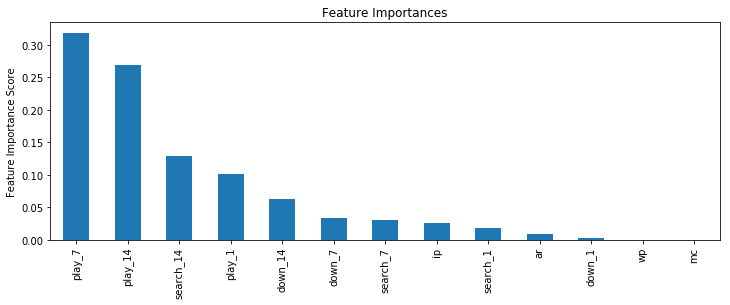

In [80]:
gbm = GradientBoostingClassifier(random_state=1)
modelfit(gbm, x_train, y_train, feature_names)

In [81]:
print("Training DataSet Score: %f" % (gbm.score(x_train, y_train)))
print("Testing DataSet Score: %f" % (gbm.score(x_test, y_test)))

Training DataSet Score: 0.805241
Testing DataSet Score: 0.801782


In [86]:
param_test1 = {'n_estimators':range(70, 101 ,10)}
gsearch1 = GridSearchCV(
    estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
    param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=500, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [87]:
print(gsearch1.grid_scores_)
print('Best Parameter: %s' % gsearch1.best_params_)
print('Best Score: %f' % gsearch1.best_score_)

[mean: 0.87549, std: 0.00147, params: {'n_estimators': 70}, mean: 0.87554, std: 0.00145, params: {'n_estimators': 80}, mean: 0.87554, std: 0.00144, params: {'n_estimators': 90}, mean: 0.87557, std: 0.00145, params: {'n_estimators': 100}]
Best Parameter: {'n_estimators': 100}
Best Score: 0.875566


/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [89]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [200, 400, 600, 800, 1000], 'max_depth': [5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [90]:
print(gsearch2.grid_scores_)
print('Best Parameter: %s' % gsearch2.best_params_)
print('Best Score: %f' % gsearch2.best_score_)

[mean: 0.87474, std: 0.00157, params: {'min_samples_split': 200, 'max_depth': 5}, mean: 0.87468, std: 0.00160, params: {'min_samples_split': 400, 'max_depth': 5}, mean: 0.87467, std: 0.00148, params: {'min_samples_split': 600, 'max_depth': 5}, mean: 0.87475, std: 0.00158, params: {'min_samples_split': 800, 'max_depth': 5}, mean: 0.87476, std: 0.00155, params: {'min_samples_split': 1000, 'max_depth': 5}, mean: 0.87528, std: 0.00162, params: {'min_samples_split': 200, 'max_depth': 7}, mean: 0.87532, std: 0.00150, params: {'min_samples_split': 400, 'max_depth': 7}, mean: 0.87533, std: 0.00148, params: {'min_samples_split': 600, 'max_depth': 7}, mean: 0.87529, std: 0.00149, params: {'min_samples_split': 800, 'max_depth': 7}, mean: 0.87519, std: 0.00152, params: {'min_samples_split': 1000, 'max_depth': 7}, mean: 0.87529, std: 0.00142, params: {'min_samples_split': 200, 'max_depth': 9}, mean: 0.87549, std: 0.00152, params: {'min_samples_split': 400, 'max_depth': 9}, mean: 0.87546, std: 0.001

/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [95]:
param_test3 = {'min_samples_leaf':range(100,151,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=9,min_samples_split=800,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=800, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': [100, 110, 120, 130, 140, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [96]:
print(gsearch3.grid_scores_)
print('Best Parameter: %s' % gsearch3.best_params_)
print('Best Score: %f' % gsearch3.best_score_)

[mean: 0.87582, std: 0.00153, params: {'min_samples_leaf': 100}, mean: 0.87580, std: 0.00148, params: {'min_samples_leaf': 110}, mean: 0.87574, std: 0.00149, params: {'min_samples_leaf': 120}, mean: 0.87568, std: 0.00149, params: {'min_samples_leaf': 130}, mean: 0.87575, std: 0.00148, params: {'min_samples_leaf': 140}, mean: 0.87572, std: 0.00150, params: {'min_samples_leaf': 150}]
Best Parameter: {'min_samples_leaf': 100}
Best Score: 0.875819


/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [100]:
param_test4 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=9, min_samples_split=800, min_samples_leaf=100, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=800, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [101]:
print(gsearch4.grid_scores_)
print('Best Parameter: %s' % gsearch4.best_params_)
print('Best Score: %f' % gsearch4.best_score_)

[mean: 0.87600, std: 0.00147, params: {'subsample': 0.6}, mean: 0.87596, std: 0.00142, params: {'subsample': 0.7}, mean: 0.87595, std: 0.00142, params: {'subsample': 0.75}, mean: 0.87596, std: 0.00146, params: {'subsample': 0.8}, mean: 0.87603, std: 0.00142, params: {'subsample': 0.85}, mean: 0.87595, std: 0.00138, params: {'subsample': 0.9}]
Best Parameter: {'subsample': 0.85}
Best Score: 0.876027


/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [107]:
param_test5 = {'learning_rate':[0.1,0.05,0.01,0.005,0.001]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=100,max_depth=9, min_samples_split=800, min_samples_leaf=100, subsample=0.85,random_state=10),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=800, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.85, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [108]:
print(gsearch5.grid_scores_)
print('Best Parameter: %s' % gsearch5.best_params_)
print('Best Score: %f' % gsearch5.best_score_)

[mean: 0.87603, std: 0.00142, params: {'learning_rate': 0.1}, mean: 0.87609, std: 0.00149, params: {'learning_rate': 0.05}, mean: 0.87570, std: 0.00153, params: {'learning_rate': 0.01}, mean: 0.87551, std: 0.00152, params: {'learning_rate': 0.005}, mean: 0.87522, std: 0.00155, params: {'learning_rate': 0.001}]
Best Parameter: {'learning_rate': 0.05}
Best Score: 0.876086


/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)



Model Report
Accuracy : 0.811
AUC Score (Train): 0.879490
CV Score : Mean - 0.8760861 | Std - 0.00148567 | Min - 0.8741274 | Max - 0.8786741


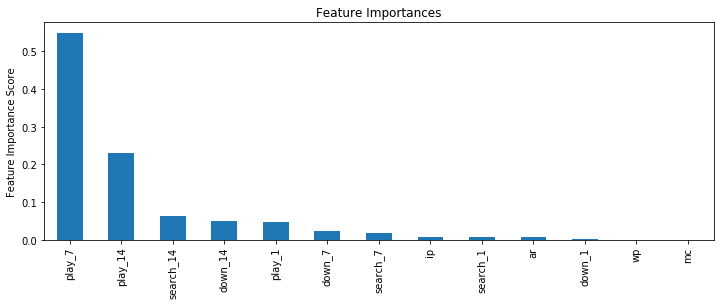

In [110]:
gbm = GradientBoostingClassifier(learning_rate = 0.05, n_estimators=100,max_depth=9, min_samples_split=800, min_samples_leaf=100, subsample=0.85,random_state=10)
modelfit(gbm, x_train, y_train, feature_names)

In [111]:
print("Training DataSet Score: %f" % (gbm.score(x_train, y_train)))
print("Testing DataSet Score: %f" % (gbm.score(x_test, y_test)))

Training DataSet Score: 0.810952
Testing DataSet Score: 0.804420
